<a href="https://colab.research.google.com/github/elliemci/building-LLM/blob/main/gpt_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of a GPT model

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/LLM
%ls

/content/drive/MyDrive/Colab Notebooks/LLM
attention_comp.ipynb      __pycache__/                   token_embedding.ipynb
attention_comp.py         pytorch_wormup.ipynb           tokenizing_text.ipynb
gpt_implementation.ipynb  sliding_window_sampling.ipynb
gpt_model.png             the-verdict.txt


In [ ]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import tiktoken

## GPT architecture

The implementation starts with a mental model, a placeholder architecture of individiual parts which will be coded and assembled in the following order:

1. GPT backbone
2. Layer Normalization
3. GELU Activation
4. Feed forward network
5. Shortcut connections
6. Transformer block
7. Final GPT model

In [ ]:
# the smallest GPT-2 consisting of 124 million parameters model configuration via python dictionary
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 1024,# Context length
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-Key-Value bias vector in linear layer of multihead attention
}

In [ ]:
class GPTBackbone(nn.Module):
  """ Model architecture class which consists of token and positional embeddings,
      dropout, dummy transformer blocks, dummy final normaliztion layer, and linear o
      output layer. The forward methods describes the data flow though the model -
      computation of token and positional embeddings, application of dropout,
      transformer block data processing, final normalization, logits from linear layer"""
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(
        *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)

    return logits

class DummyTransformerBlock(nn.Module):
  """ A place holder class for the transformer block. """
  def __init__(self, cfg):
      super().__init__()

  def forward(self, x):
      return x

class DummyLayerNorm(nn.Module):
  """ A place hodlder class for layer normalization. """
  def __init__(self, normalized_shape, eps=1e-5):
      super().__init__()

  def forward(self, x):
      return x

In [ ]:
# test of general architecure with batch of two tokenized text
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)

print(f"tokenized batch:\n{batch}")

tokenized batch:
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
# initialize a GPTBackbone instance
torch.manual_seed(123)

model = GPTBackbone(GPT_CONFIG_124M)
# feed in th etokenized batch
logits = model(batch)

print(f"Output has {logits.shape[0]} text samples, \
each text consists of {logits.shape[1]} tokens, and \
each token is a {logits.shape[2]}-dimensional vector, \
coresponding to the size of the tokenizer's vocabululary.")
print(f"\nlogits:\n{logits}")

Output has 2 text samples, each text consists of 4 tokens, and each token is a 50257-dimensional vector, coresponding to the size of the tokenizer's vocabululary.

logits:
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


## Layer Normalization

Some layer experience unstable training dynamics with vanishing or eploding gradients, leading to the whole network having difficulty learning underlying patterns.
**Layer normalization** adjust s the outouts of a network layer to have a mean of 0 and an unit variance, which speeds up the convergence and ensures consistent training. Its applied before and after multi-head attention module and before the final outout layer.

In [ ]:
class LayerNorm(nn.Module):
  """Layer normalization operates on the last dimention of
     the input tensor which represents embedding dimension """
  def __init__(self, emb_dim):
    super().__init__()
    # a small constant added to the variance to prevent division by zero during normalization
    self.eps = 1e-5
    # trainable parameters of input dimension, which allow the model to learn appropriate scaling and shifting
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    # use keepdim=True for the output tesnor to retain the same shape as the input tensor
    mean = x.mean(dim=-1, keepdim=True)
    # computation of statistics is performed along the last dim, dim=-1, of the tensor [batch_size, num_tokens, embedding_size]
    var = x.var(dim=-1, keepdim=True, unbiased=False) # unbiased=False means n instead of n-1 is used in variance formula
    norm_x = (x - mean) / torch.sqrt(var + self.eps)

    return self.scale * norm_x + self.shift

In [ ]:
# test LayerNorm module
torch.manual_seed(123)
# turn off the scientific notation to see the 0s
torch.set_printoptions(sci_mode=False)


# create to training examples, 5-dim each
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())

out = layer(batch_example)
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(f"linear layer output of random input:\n{out}")
print("Mean:\n", mean)
print("Variance:\n", var)


ln = LayerNorm(emb_dim=6)
ln_out = ln(out)

mean = ln_out.mean(dim=-1, keepdim=True)
var = ln_out.var(dim=-1, unbiased=False, keepdim=True)

print("Mean of linear layer normalized output:\n", mean)
print("Variance of linear layer normalized outout:\n", var)

linear layer output of random input:
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)
Mean of linear layer normalized output:
 tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Variance of linear layer normalized outout:
 tensor([[0.9995],
        [0.9997]], grad_fn=<VarBackward0>)


## Feed Forward with GELU activation

Gaussian Error Linear Unit activation is deefined as GELU(x)=x Φ(x), where Φ(x) is the cumultaive distribution function of the standard Gaussian distribution. GELU is a smooth, non-liner function that approximated ReLU but allows a small non-zero gradient for negative values. Its smoothness leads to better optimization during training

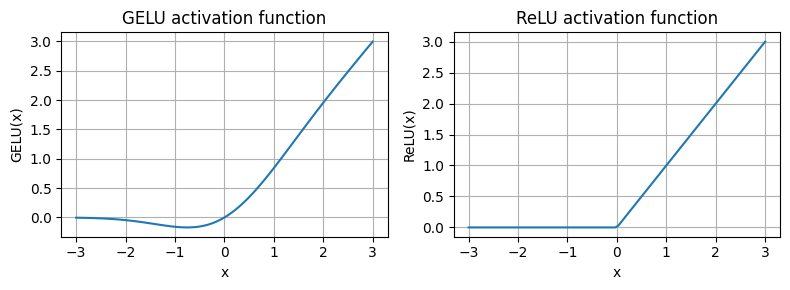

In [ ]:
import matplotlib.pyplot as plt
gelu, relu = nn.GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
class GELU(nn.Module):
  """ Implementation of computationally cheaper approximation of
      Gaussian Error Linear Unit activation function. """
  def __init__(self):
      super().__init__()

  def forward(self, x):

      return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [ ]:
class FeedForward(nn.Module):
  """ A small neural network consisting of two linea layers and
      GELU activation function"""
  def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

  def forward(self, x):
        return self.layers(x)

## Shortcut connections

The shortcut connections are added to mitigate vanishing gradients. They involve adding the inputs of a layer to its outputs, creating an alternative path bypassing certain layers, achived by adding the output of one layer to the output of a later layer

### Example of neural network with shortcut connections

In [ ]:
class TestDNNwShortcuts(nn.Module):
  """ Deep Neural Network with 5 layer, each being a liner layer with a
      GELU activation function, with an optional  shortcut connections"""
  def __init__(self, layer_sizes, use_shortcut):
      super().__init__()
      self.use_shortcut = use_shortcut
      self.layers = nn.ModuleList([
          # Implement 5 layers
          nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), nn.GELU()),
          nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), nn.GELU()),
          nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), nn.GELU()),
          nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), nn.GELU()),
          nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), nn.GELU())
      ])

  def forward(self, x):
      for layer in self.layers:
          # Compute the output of the current layer
          layer_output = layer(x)
          # Check if shortcut can be applied
          if self.use_shortcut and x.shape == layer_output.shape:
              x = x + layer_output
          else:
              x = layer_output
      return x

In [ ]:
def print_gradients(model, x):
  """ Computes the loss gradient for each layer as the mean absolute gradient
      of the inputs x outputs gradient values, and prints it. """
  # Forward pass
  output = model(x)
  target = torch.tensor([[0.]])

  # Calculate loss based on how close the target and output are
  loss = nn.MSELoss()
  loss = loss(output, target)

  # Backward pass to calculate the gradients
  loss.backward()

  for name, param in model.named_parameters():
      if 'weight' in name:
        # Print the mean absolute gradient of the weights
        print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [ ]:
# initalize the with each layer accepts 3 inputs and
# returns 3 outputs exept the last layer which returns a single output
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123) # specify random seed for the initial weights for reproducibility

# network without shortcuts
model_without_shortcut = TestDNNwShortcuts(layer_sizes, use_shortcut=False)

model_with_shortcut = TestDNNwShortcuts(layer_sizes, use_shortcut=True)

# the gradients become smaller from the last to the first
print("Gradients of the model without shortcuts:\n")
print_gradients(model_without_shortcut, sample_input)

# the gradient value stabalizes progressing towards the first layer
print("\nGradients of the model with shortcuts:\n")
print_gradients(model_with_shortcut, sample_input)

Gradients of the model without shortcuts:

layers.0.0.weight has gradient mean of 0.00020174118981231004
layers.1.0.weight has gradient mean of 0.00012011769285891205
layers.2.0.weight has gradient mean of 0.0007152436301112175
layers.3.0.weight has gradient mean of 0.00139885104727
layers.4.0.weight has gradient mean of 0.005049602594226599

Gradients of the model with shortcuts:

layers.0.0.weight has gradient mean of 0.0014336268650367856
layers.1.0.weight has gradient mean of 0.004820032045245171
layers.2.0.weight has gradient mean of 0.0041160923428833485
layers.3.0.weight has gradient mean of 0.00588441826403141
layers.4.0.weight has gradient mean of 0.03249199315905571


## Transformer Block

Transformer black utalizes layer normalization, GELU activation, masked multi-head attention, feed forward module, and shortcut connections. Its a fundamental building block repated many times.

In [ ]:
! jupyter nbconvert --to python attention_comp.ipynb

[NbConvertApp] Converting notebook attention_comp.ipynb to python
[NbConvertApp] Writing 21231 bytes to attention_comp.py


In [ ]:
# import MultiHeadAttention from attention_comp.ipynb
from attention_comp import MultiHeadAttention

class TransformerBlock(nn.Module):
  """ Transformer block class that defines layer normalization,
      multy-head attention, feed forward including GELU activation
      and shortcut connections, configured based on a configuration
      dictionary, and dropout to prevent overfitting.
      The forward pass consists of two components followed by a
      shortcut connection, which helps the gradient flow
      flow through the network. The output is a context vector
      that encapsulates information from the entire input sequence."""
  def __init__(self, cfg):
    super().__init__()

    self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])

    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_resid = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_resid(x)
    x = x + shortcut  # Add the original input back

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_resid(x)
    x = x + shortcut

    return x

In [ ]:
torch.manual_seed(123)

# instantiate the transformer block with GPT_CONFIG_124M dictionary
block = TransformerBlock(GPT_CONFIG_124M)
# test the Transformer block
x = torch.rand(2, 4, 768)
output = block(x)

# the content of each output vector is re-encoded to integrate
# contextual information from the entire input sequence
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## Coding the GPT-model

The flow of data though the GPT model: tokenized text is embeded and augmented with positional embeddings. The combined tensor is passed though a series of 12 transformer blocks, containing multi-head attention and feed forward layers with layer normalization and dropout. The ouput of the last transformer block goes through a final normalization layer and a linear output layer.

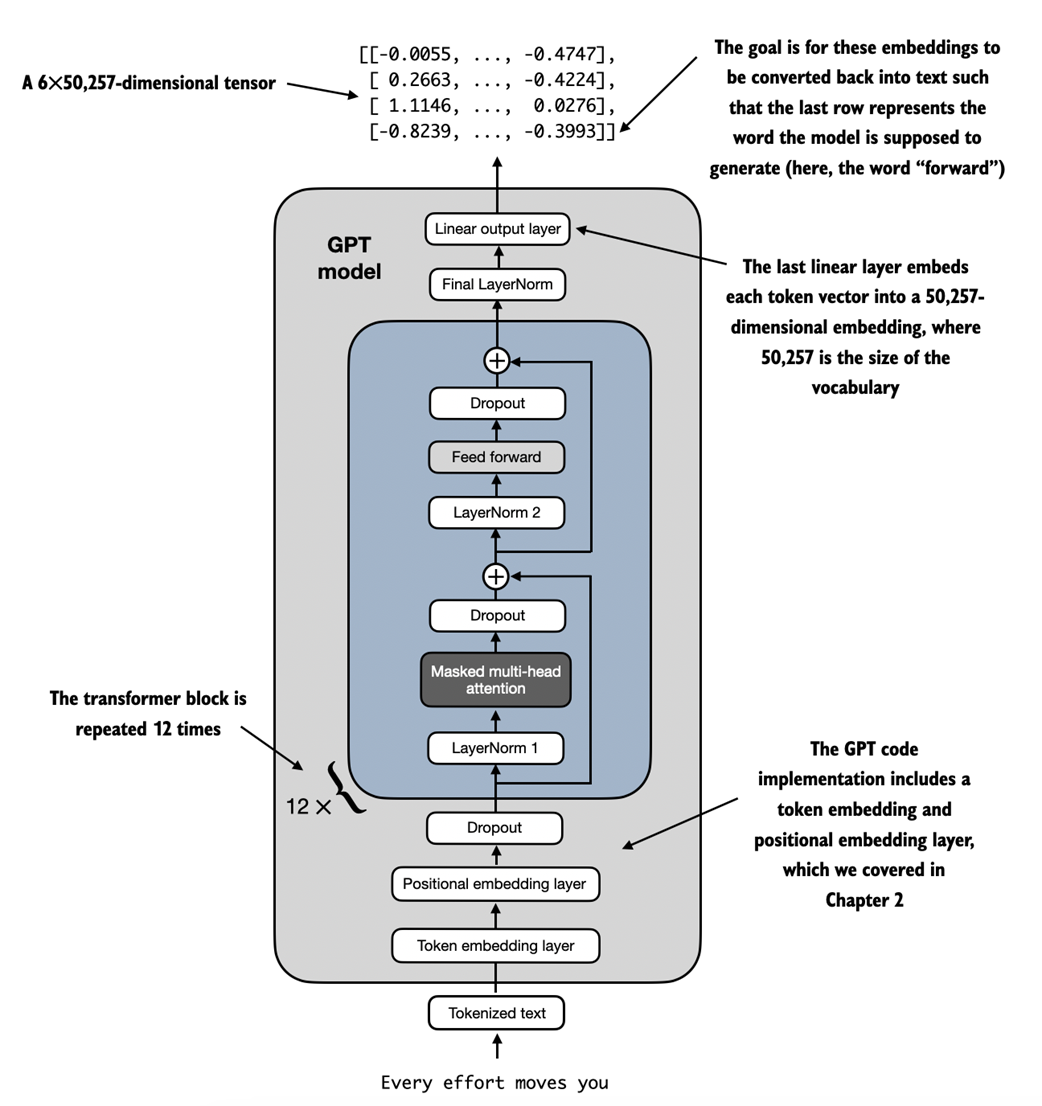

In [ ]:
from IPython.display import Image
Image(filename='gpt_model.png')

In [ ]:
class GPTModel(nn.Module):
  """ GPT model which initializes the token and positional embedding layers
      passing the configuration dictionary cfg, creating sequential stack of
      n_layers TransformerBlock. A layerNorm is applied to the transformer block
      outputs to stabilized the learning process. The final linear out projects
      the transformer's output into the vocabulary space of the tokenizer to
      generate logits for each token. The forward method takes a batch of input
      token indices, computes their embeddings, applies positional embeddings,
      passes the sequence though the transformer bocks, normalizes the final
      output and computes the logits, which are the unnormalized probabilities of
      tokens and text."""
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)

    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)

    return logits

In [ ]:
torch.manual_seed(123)
# initialize 124 million parameter GPT model using the config dictionaty
model = GPTModel(GPT_CONFIG_124M)

# feed in a batch of text
out = model(batch)

print("Input batch:\n", batch)
print(f"\nOutput batch with size {out.shape}:\n{out}")

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output batch with size torch.Size([2, 4, 50257]):
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
# total number of parameters in the model's parameter tensor:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


The original GPT-2 architecture is reusing the weights from the token embeding layer in its ooutput layer.

In [ ]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


The token embeding and output layers are very large due to the number of rows in the tokenizer's vocabulary. Removing the output layers parameters count from the total model count gives the number of the trainable parameters

In [ ]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [ ]:
# compute memory requirements for the 163 million paramters GPTModel object
# assuming each parameter is a 32-bit float taking up 4 bytes
total_size_bytes = total_params * 4
# convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## Generate text

Convert the tensor outputs of GPT model back into text: decode the output tensor, select tokens based on a probability distribution and converts them into text.

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    """ A function that uses GPT model instance to generate one token at a time
        and appends it to the context. It iterates for a specified number of new
        tockens to be generated, crops the current context to the model's maximum
        context size, computes prediction and selects the next token based on the
        highest probability. """
    for _ in range(max_new_tokens):
      # crop current context idx, an array indeces of size batch x n_token,
      # if exceeds suported context size
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        # consider the tokens of the last time step, thus [batch, n_token, vocab_size]
        # becomes [batch, vocab_size]
        logits = logits[:, -1, :]
        # convert logits into brobabilities
        probas = torch.softmax(logits, dim=-1)
        # identify the position with the highest value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        # append sampled index to the running sequence, where idx is [batch, n_tokens+1]
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [ ]:
# test generate_text_simple() with "Hello, I am"
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded token ids:", encoded)
# add a batch dimension
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

# put model into .eval() mode, which disables dropout
model.eval()
# use the generate_text_simple() on the encoded input tensor
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print(f"Output token ids:{out}")
print(f"Output length:", len(out[0]))

# convert IDs back to text with .decode methods of the tokenizer
decoded_text = tokenizer.decode(out.squeeze(0).tolist())

print(f"Input text:\n{start_context}")
print(f"Output text:\n{decoded_text}")

# NB:The model does not produce coherent text as it haven't been trained yet


encoded token ids: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])
Output token ids:tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10
Input text:
Hello, I am
Output text:
Hello, I am Featureiman Byeswickattribute argue
